# Lesson 2: Deploying a model

In lesson 2 I learned how to deploy a model and encapsulate it in a nice GUI using grad.io! In class we also covered a few tips on how to build and better analyze training sets, such as data augmentation techniques and using a trained model to assist with data cleaning and analysis.

For this mini-project I will train a new model, use it to clean our data, and deploy it to huggingface spaces using gradio. Huggingface spaces allow for the easy creation of simple, interactive web pages and are perfect for deploying models and allowing users to interact with them. I'll also try some of the data augmentation and cleaning techniques we discussed in lecture.

In [ ]:
! pip install duckduckgo_search
! pip install fastai

For this project, I'll build an image classifier that identifies different birds of prey species. 

Birds of Prey https://en.wikipedia.org/wiki/Bird_of_prey are 'hypercarnivorous bird species that actively hunt and feed on other vertebrates (mainly mammals, reptiles and other smaller birds). In addition to speed and strength, these predators have keen eyesight for detecting prey from a distance or during flight, strong feet with sharp talons for grasping or killing prey, and powerful, curved beaks for tearing off flesh.' 

Sounds pretty scary. I'll be focusing on distinguishing between the following classes: Eagles, Hawks, Falcons, Owls, and Vultures. I know next to nothing about birds, so I have a hard time telling some of these apart. 

In [3]:
from duckduckgo_search import ddg_images
from fastdownload import download_url
from fastcore.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from time import sleep

I'll use similar techniques to the previous lesson to download some images from the internet in order to create a dataset. I'd like the dataset to show our birds in a variety of states, so in order to accomplish that I'll use the keywords 'flying', 'perched', and 'diving' in that hope that this allows our model to generalize well across photos from different angles. 

In [4]:
classes = ['eagle', 'hawk', 'falcon', 'owl', 'vulture']
actions = ['flying', 'perched', 'diving']

path = Path('birds_of_prey')

def search_images(term, max_images=30):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

for c in classes:
    p = path/c
    dest = (p)
    dest.mkdir(parents=True, exist_ok=True)
    for action in actions:
        download_images(dest, urls=search_images(f'{c} {action}'), max_pics=50)
        sleep(5)
    download_images(dest, urls=search_images(f'{c}'), max_pics=50)
    sleep(5)
    resize_images(p, max_size=400, dest=p)

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#8) [None,None,None,None,None,None,None,None]

Rather than using a simple Resize like last time, I'll use RandomResizedCrop, which randomly selects a cropped subsection of the image of at least a minimum size. I'll choose min_scale to be 0.6 so the augmented images will include at least 60% of the original image. This is a useful technique because it means that during training rather than looking at the same image across multiple epochs the model will train on multiple unique croppings of it.

Our dataset will be split into 80% training data, 20% validation data.

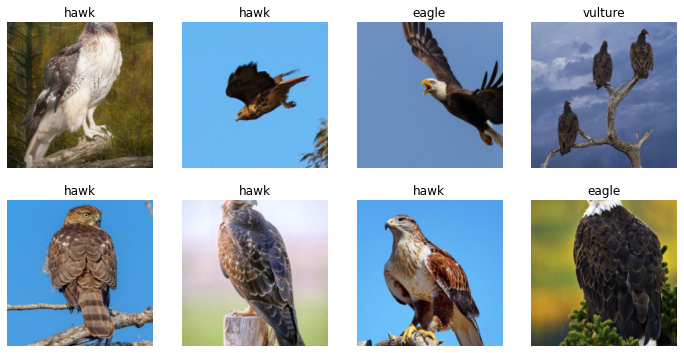

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=78),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(256, min_scale=0.6)
).dataloaders(path, bs=8)

dls.show_batch(max_n=10)

These images look excellent. I tried to use queries that would allow for our dataset to include birds in various motions, and it looks like I probably succeeded. Next, let's go ahead and train our model. 

As we discussed in lecture, it's useful to train a model first and then use the results to:
* find any images that shouldn't be in the dataset
* analyze what our model struggles with


I had some great success with a *convnext* network for the car make classifier, so I see no reason not to try that pre-trained network again. Hopefully we can achieve similar results with the power of *transfer learning!*

In [13]:
torch.cuda.empty_cache()
import gc
gc.collect()

23

In [14]:
learn = vision_learner(dls, 'convnext_large_in22ft1k', metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.444219,0.125811,0.026786,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.139226,0.108490,0.026786,00:38
1,0.103007,0.063007,0.017857,00:38
2,0.102032,0.068125,0.008929,00:38
3,0.072045,0.072990,0.008929,00:38


An error rate of < 1% is quite an incredible result. I will see if any data cleaning can further improve the model, but it might be hard to find improvement in a result that is already so good! It's amazing that we can use *transfer learning* to get a super-accurate model for a very specific image classification task in under 5 minutes!

One visualization technique I can use to see if there is any particular pattern to misclassifications our model makes is a *confusion matrix*.

In this case, it just confirms our model is great:

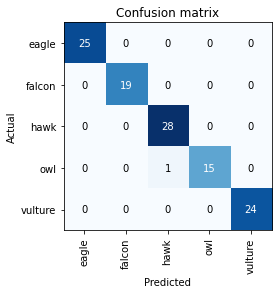

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Another useful technique is to take a look at the images that our model accrues the most loss from misclassifying. If any faulty/incorrect images made it in to our dataset, our model should tend to struggle with those the most, so this is useful in that it allows us to view potential candidates to be removed from our dataset as part of *data cleaning*.

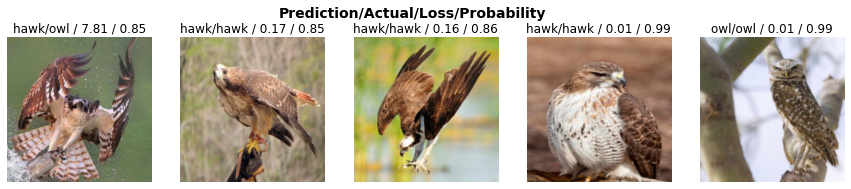

In [16]:
interp.plot_top_losses(5, nrows=1)

This is hardly useful to us in this case, as our model only misclassified a single image in our training set. (I would not classify this image as an owl either, but I am no bird expert. I think it is safe to leave this image in the dataset).

Another technique is to use the fastai ImageClassifierCleaner mentioned in lecture, which provides a GUI for going through images in the dataset and allows for removing and relabeling. Once again, in our case this is hardly useful unless you enjoy looking at photos of beautiful birds.

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

After glancing over these I couldn't really find arguments for removing any single image in the dataset. If I had found some, I could relabel/remove appropriately and then re-train the model, in order to hopefully see better performance! At this point I could move on to deploying the model, but I'm really curious as to how our model does on some more data -- were our great results just a fluke or did our model really generalize that well? 

I'll comiple a test-set using some new images. I didn't see many images in the dataset of birds with wings fully outstretched when using *ImageClassifierCleaner* so I'll try grabbing a collection of those.

In [18]:
path = Path('birds_of_prey_test')

for c in classes:
    p = path/c
    dest = (p)
    dest.mkdir(parents=True, exist_ok=True)
    download_images(dest, urls=search_images(f'{c} wings out'), max_pics=50)
    sleep(5)
    resize_images(p, max_size=400, dest=p)

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#1) [None]

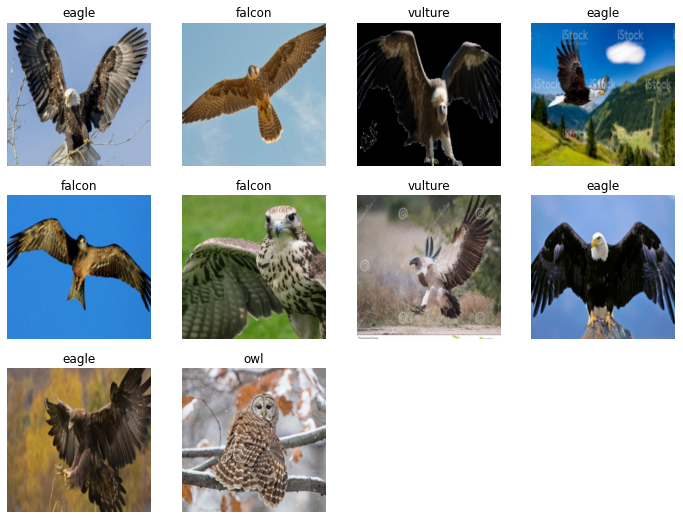

In [19]:
test_dl = learn.dls.test_dl(get_image_files(path), bs=16, with_labels=True, shuffle=True)
test_dl.show_batch(max_n=10)

In [20]:
preds, actuals = learn.get_preds(dl=test_dl)
error_rate(preds, actuals)

TensorBase(0.0643)

An error rate of 6%, despite being much higher than the 1% we saw earlier, is still a great result and shows that our model is able to generalize reasonably well on some different-looking images. If we wanted to improve our model we could construct a new dataset including these new images and expect our model to perform better on these, but our performance is great already so I see no need to push for small percentage points (at least in this practice notebook). 

Finally, it's time to deploy the model. 

In order to deploy the model, we need to export it to a pickle file! This file will save the state of the model and allow us to import it and use it elsewhere without training it again.

In [ ]:
learn.export()

This has saved the model to a file *export.pkl* which contains all of the parameter values for our model along with other pieces of metadata we can use to load the model elsewhere. We can do that with *load_learner*.

Next, I'll write a few lines of code to create a grad.io app, which is just a nice frontend around our model that allows users to submit custom input and get predictions -- it's super easy! I can then deploy this using HuggingFace spaces. 

In lecture we used a package called *viola* to write the app code here in our notebook and then export it. I would never do that in real life, so I'm just going to write the app the normal-person way, and paste a link to the deployment below. The file is 'app.py' and it is written in the same directory as this notebook if you'd like to check it out.

https://huggingface.co/spaces/lowrollr/birds_of_prey_classifier